Jako, że w wielu przypadkach potrzebowałem najlepszego wyboru zmiennych do modelu, które zostaną wykorzystane postanowiłem usestymatyzować wiedze oraz zasoby. Głównym powodem tego artykuły będzie więc jego wykorzystanie w przyszłości, kiedy zajdzie taka potrzeba. Mam jednak nadzieję, że wyniesiecie z niego jak najwięcej a może sami uporządkujecie to co już wiecie.

### Dlaczego potrzebujemy sprawnego mechanizmu wyboru zmiennych?

Rozważania na ten temat najlepiej zacząć od podania pierwszego poważnego powodu. Selekcje zmiennych wykorzystuje się w głównej mierze do zredukowania ilości "inputów" w celu zmniejszenia kosztów przetwarzania oraz w często aby poprawić jakość dopasowania modelu. Innymi słowy działamy tak, aby przy tworzeniu modelu zostały nam właśnie te zmienne, które mają największą moc predykcji. Reszta zmiennych robi często wolny przebieg na etapie przetwarzania a jednak wykorzystuje często dużą część mocy obliczeniowej maszyny. Dzięki selekcji możemy w przejrzysty sposób zidentyfikować te zmienne, które są najważniejsze przy tworzeniu predykcji.

### Rodzaje algorytmów selekcji zmiennych

Jak możemy przeczytać w https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/ wyróżniamy dwa podstawowe rodzaje algorytmów selekcji zmiennych. Wrapper Feature Selection Methods oraz Filter Feature Selection Methods

W pierwszym przypadku, tworzy się wiele modeli, różniących się miedzy sobą zmiennymi wejściowymi jakie zostały wybrane do jego budowy. Następnie na podstawie miar dokładności odpowiednich modeli wybierany zostaje zestaw "najlepszych" zmiennych. Często wygląda to na dwa sposoby.

Tworzymy model bez żadnych zmiennych a następnie dodajemy po jednej zmiennej sprawdzając jego miary dopasowania. Dodajemy nowe zmienne aż dodanie kolejnej nie poprawia w sposób znaczący jakość modelu.

Tworzymy model ze wszystkimi zmiennym a następnie odejmujemy po jednej, ciągle sprawdzając miary modelu. W taki sposób możemy znaleźć odpowiedni zestaw kolumn dla naszego zbiór wejściowego do modelu.

Kolejność zmiennych dodawanych lub odejmowanych również ma istonte znaczenie. 
Kolejność zmiennych dodawanych lub odejmowanych również ma istotne znaczenie. W tym przypadku nie zawracamy sobie głowy rodzajem zmiennej (typu kategorycznego czy numerycznego) bo interesuje nas tak naprawdę ten docelowy zestaw zmiennych przy których otrzymujemy maksymalizację jakości modelu.

Drugi grupa metod selekcji zmiennych wykorzystuje techniki statystyczne do oszacowania związku każdej ze zmiennych niezależnych ze zmienną zależną (wynikową). Na podstawie danej statystyki możemy więc "odfiltrować" te, które prezentują niesatysfakcjonującą wartości statystyki. Przy wykorzystaniu tej grupy metod musimy zwrócić uwagę na to z jakimi typami zmiennych mamy do czynienia.

Sprawdźmy zatem jak przedstawia się ta metoda na danych piłkarskich, które w dalszym ciągu analizujemy. Naszą zmienną wynikową jest zmienna typu kategorycznego, natomiast jeśli chodzi o zmienne wejściowe - w zbiorze danych posiadamy praktycznie cały przekrój typów zmiennych. Zerknijmy na dane:

In [17]:
import pandas as pd
import os
import time
import pymysql
import psycopg2
import sklearn

In [6]:
loc_to_functions =  "D:\data_football\Football_prediction_ML\Football_ML"
    
os.chdir(loc_to_functions)
        
import functions_for_dataset_preparation as f1

In [4]:
league_abb = 'SP1'

In [5]:
connection_aws = psycopg2.connect(user = "####",
                                  password = "####",
                                  host = "####",
                                  port = "5432",
                                  database = "####")
    #cursor_aws = connection_aws.cursor()
        
dataset = pd.read_sql('SELECT * FROM public."'+league_abb+'" WHERE "FTHG" is NOT NULL AND "FTAG" is NOT NULL', connection_aws)
dataset["Date"] =    pd.to_datetime(dataset.Date ,  format = "%Y-%m-%d") 

marketv =  pd.read_sql('SELECT * FROM public."budget_'+league_abb+'"', connection_aws)     

In [7]:
df_final = f1.dataset_preparation(dataset, league_abb, marketv)
    
df_final = df_final.drop('Mean_away_goals',axis=1)
df_final = df_final.dropna()
    

In [9]:
df_final.tail()

,HTGD,ATGD,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,DiffPts,DiffFormPts,DiffLP,Mean_home_goals,H2H_Diff,ELO_diff,Total_Diff,LP_Diff,FTR,Goals_mean_diff
4657,0.259259,-0.666667,0,0,0,0,0,0,0,0,18,-1.0,1,1.41429,9,101,1.982210,-12,0,0.80192
4658,-0.296296,0.074074,0,0,0,0,0,0,0,0,-5,0.0,8,0.96980,3,-116,0.405778,5,0,-0.00999
4659,-0.333333,-0.037037,0,0,0,0,0,0,0,0,-10,1.0,7,2.59286,-9,-126,0.182038,7,0,1.98049
4660,1.185185,0.444444,0,0,0,0,0,0,0,0,12,-3.0,-8,5.02857,3,249,3.550678,-4,1,4.00795
4661,-0.259259,0.037037,0,0,0,0,0,0,0,0,-5,-1.0,0,1.41429,3,52,3.056716,4,0,1.10810


Zmienne typu numeryczne: HTGD, ATGD, DiffPts, DiffFormsPts, DiffLP, Mean_home_goals, HWG_Diff, ELO_diff, Total_Diff, LP_Diff, Goals_mean_diff. 

Zmienne zarówno typu integer jak i float.

Dodatkowo posiadamy również zmienne typu kategorycznego, HTWinnStreak3 ... ATLossStreak5, przyjmujące dwie kategorie 0/1, które moga równiez zostac za uznane za rodzaj zmiennej logicznej po uprzednim przekonwertowaniu.

Przy takim rozkładzie zmiennych (numeryczne zmienne wejściowe oraz kategoryczn zmienna wyjściowa) możemy wykorzystać:
    współczynnik korelacji ANOVA oraz
    współczynnik stopnia Kendall'a

Podział zbioru na X oraz y

In [48]:
df_final["FTR"] = df_final["FTR"].astype('category')

### Zmienne wejściowe numeryczne, zmienna wyjściowa kategoryczna

In [15]:
X, y = df_final.drop('FTR',axis=1).reset_index(drop = True), df_final['FTR'].reset_index(drop = True)

In [50]:
df_final.select_dtypes(include='number').head(2)

,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP,Mean_home_goals,H2H_Diff,ELO_diff,Total_Diff,LP_Diff,Goals_mean_diff
0,0.0,0.5,-2,0.0,5,1.6,0,27,1.47931,5,0.45
1,0.0,0.5,-2,0.0,5,1.6,0,27,1.47931,5,0.45


In [20]:
from sklearn.feature_selection import f_classif

In [55]:
f_classif(X.select_dtypes(include='number'), y)[0]

array([273.89813418, 294.55492913, 442.81969671, 247.88494511,
       864.00595966, 130.29097375, 215.37539977, 773.43604339,
       384.68533162, 263.26943018, 131.72880132])

f_classif zwaraca dwie tablice: 
    Zbiór wartości statystyki F pomiędzy poszczególymi zmiennymi a zmienną wyjściową
    Zbiór wartości p-value dla danej statystyki F poszczególnej zmiennej

In [56]:
pd.DataFrame({"Veriables" : X.select_dtypes(include='number').columns,
              "F_stat":f_classif(X.select_dtypes(include='number'), y)[0],
              "p_value":f_classif(X.select_dtypes(include='number'), y)[1]})

,Veriables,F_stat,p_value
0,HTGD,273.898134,7.943703e-60
1,ATGD,294.554929,4.545048e-64
2,DiffPts,442.819697,5.481588e-94
3,DiffFormPts,247.884945,1.860410e-54
4,DiffLP,864.005960,2.275804e-174
5,Mean_home_goals,130.290974,8.773028e-30
6,H2H_Diff,215.375400,1.055697e-47
7,ELO_diff,773.436043,1.276298e-157
8,Total_Diff,384.685332,2.297429e-82
9,LP_Diff,263.269430,1.231137e-57


Wartość statystyki F dla poszczególnej zmiennej sprawdza nam, czy pogrupowane zbiory danej zmiennej na podstawie kategorii zmiennej wyjściowej, mają statystycznie znacząco różne zmienne.

In [65]:
from sklearn.feature_selection import SelectKBest

fs = SelectKBest(score_func=f_classif, k=5)

X_selected = fs.fit_transform(X.select_dtypes(include='number'), y)

In [67]:
X.select_dtypes(include='number').columns[fs.get_support()]

Index(['ATGD', 'DiffPts', 'DiffLP', 'ELO_diff', 'Total_Diff'], dtype='object')

### Zmienne wejściowe kaegoryczne, zmienna wyjściowa kategoryczna

In [68]:
from sklearn.feature_selection import chi2

In [69]:
df_final.select_dtypes(include='category').tail(2)

,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,FTR
4660,0,0,0,0,0,0,0,0,1
4661,0,0,0,0,0,0,0,0,0


In [70]:
pd.DataFrame({"Veriables" : X.select_dtypes(include='category').columns,
              "F_stat":chi2(X.select_dtypes(include='category'), y)[0],
              "p_value":chi2(X.select_dtypes(include='category'), y)[1]})

,Veriables,F_stat,p_value
0,HTWinStreak3,34.115387,5.193893e-09
1,HTWinStreak5,47.634346,5.136071e-12
2,HTLossStreak3,8.542965,3.468601e-03
3,HTLossStreak5,4.716147,2.988063e-02
4,ATWinStreak3,72.472202,1.694013e-17
5,ATWinStreak5,45.034120,1.936311e-11
6,ATLossStreak3,14.960250,1.098000e-04
7,ATLossStreak5,8.823058,2.974478e-03


Jak znajdziemy napisane na oficjalne stronce sklearn https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html -  wartości te mogą zostać wykorzystane do wyboru dowolnej ilości zmiennych (podanych w parametrze) z największą wartości statystyki testu chi-kwadrat z X, która może zawierać wyłącznie nieujemne wartości zmiennej, któa zaś może być zarówno zmienna tyu kategorycznego lub logicznego.

In [75]:
from sklearn.feature_selection import SelectKBest

chi = SelectKBest(score_func=chi2, k=2)

X_selected = chi.fit_transform(X.select_dtypes(include='category'), y)

In [76]:
X.select_dtypes(include='category').columns[chi.get_support()]

Index(['HTWinStreak5', 'ATWinStreak3'], dtype='object')

## Zaawansowane metody selekcji zmiennych

Inspiracja pochodzi z https://machinelearningmastery.com/calculate-feature-importance-with-python/

Wykorzystujac już wiedze z poprzedniego fragmentu materiału przejdziemy teraz do analizowania jakości modeli i jaki wpłw na jego wartośc ma selekcja zmiennych.

Zaczniemy od modelu liniowego do klasyfikacji. Generalnie, predyckja na podsatwie modelów liniowych dokonuje się porzez budowę algorytmu jako sumę zmiennych wejściowych przemnożoną przez ich odpowienide wagi (współczynniki). Wagami w naszym przyadku moga być ich wartości istotności zmiennej. Także, im wieksza wartośc współczynnika przy danej zmiennej - będzie ona miała większy wpływ na wyjściową predykcję.
Sprawdźmy na początku jak kreaują się współczynniki istotności zmiennych przy budowaniu modelów liniowych.

### Selekcja zmiennych za pomocą Regresji Logistycznej

In [81]:
from sklearn.linear_model import LogisticRegression

In [158]:
model_lr = LogisticRegression(solver='lbfgs',max_iter=1000)
model_lr.fit(X, y)
lr = pd.DataFrame({"Zmienna" : X.columns,
              "Wartość istotnosci":model_lr.coef_[0]})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

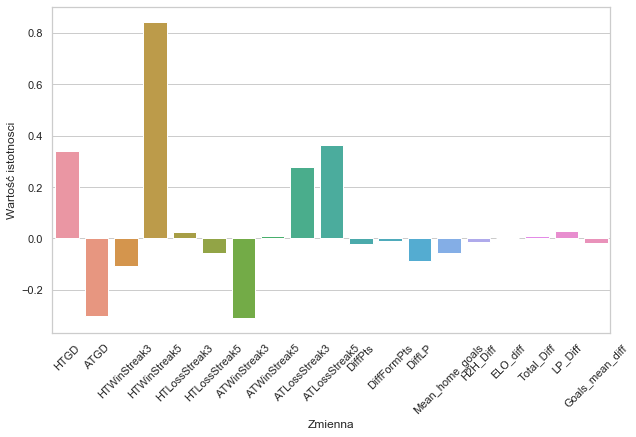

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
ax = sns.barplot(x="Zmienna", y="Wartość istotnosci", data=lr)
for label in ax.get_xticklabels():
    label.set_rotation(45)

Aby lepiej przyjrzeć się wynikom rodziele zmienne wejściowe na kategoryczne i nuemryczne jak w częsci pierwszej.

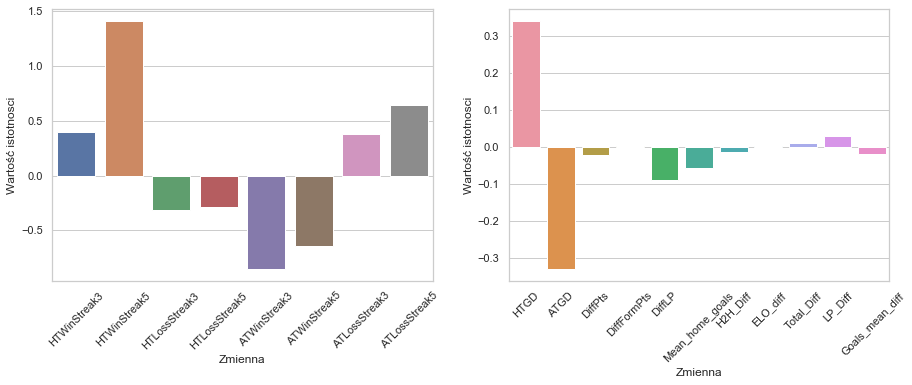

In [150]:
model_lr_n = LogisticRegression(solver='lbfgs',max_iter=1000)
model_lr_n.fit(X.select_dtypes(include='number'), y)
lr_n = pd.DataFrame({"Zmienna" : X.select_dtypes(include='number').columns,
              "Wartość istotnosci":model_lr_n.coef_[0]})
model_lr_c = LogisticRegression(solver='lbfgs',max_iter=1000)
model_lr_c.fit(X.select_dtypes(include='category'), y)
lr_c = pd.DataFrame({"Zmienna" : X.select_dtypes(include='category').columns,
              "Wartość istotnosci":model_lr_c.coef_[0]})

f, axes = plt.subplots(1, 2,  figsize=(15,5))
sns.barplot(x="Zmienna", y="Wartość istotnosci", data=lr_c , ax=axes[0])
sns.barplot(x="Zmienna", y="Wartość istotnosci", data=lr_n, ax=axes[1])
for ax in f.axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

Według modelu regresji logistycznej, zmienne Kategoryczne mają bardzo znaczacy wpływ na wyniki preydkcji. Szeczgólnie zmienna HTWinSrea5 oraz ATWinsStreak3-5. Jeśli natomiast mowa zmiennych numerycznych, tutaj zdecydowane na tle reszty wyrózniają sie zmienne reprezentujące róznicę goli strzelonych i straconych odpowiednio dla gospodarzy (HTGD) oraz gości (ATGD) przeskalowąną przez wartośc kolejki w sezonie.

### Selekcji według drzewa decyzyjnego

Przejdzmy zatem do modelu drzewa decyjnego, jak on podchodzi do naszych zmiennych.

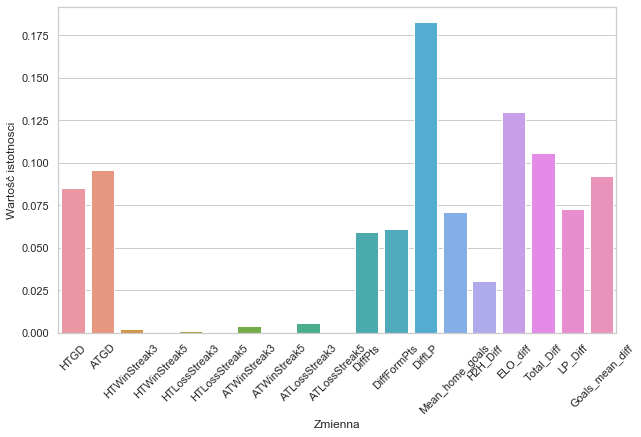

In [157]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X, y)
dt = pd.DataFrame({"Zmienna" : X.columns,
              "Wartość istotnosci": model.feature_importances_})
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
ax = sns.barplot(x="Zmienna", y="Wartość istotnosci", data=dt)
for label in ax.get_xticklabels():
    label.set_rotation(45)

Intuicyjnie te wyniki przedstawiają się bardzo dobrze. Są równiez bardzo zbliżone do tych otrzymanych z oszacowania algorytmu ANOVA dla tego zbioru danych

### Selekcja zmiennych według modelu Las losowy - random forest

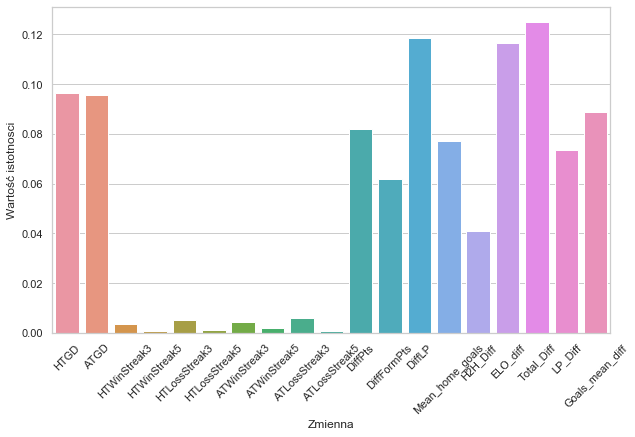

In [163]:
from sklearn.ensemble  import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)
model.fit(X, y)
rf = pd.DataFrame({"Zmienna" : X.columns,
              "Wartość istotnosci": model.feature_importances_})
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
ax = sns.barplot(x="Zmienna", y="Wartość istotnosci", data=rf)
for label in ax.get_xticklabels():
    label.set_rotation(45)

Wyniki zblożone do tych otrzymanych za pomoca drzewa decyzyjnego z tą róznica, że zarówno zmienna ELO_diff oraz Total_diff zyskały na istotności w stosunku do pozostałych. Pierwsza z nich reprezentuje róznicę w rankingu punktów ELO, druga natomiast to stosunek wartośc budżetów obu klubów.

### Selekcja zmiennych według modelu klasyfikacyjnego XBoost 

Przed budową tego modelu musimy przekonwertować zmienne kategoryczne na zmienne typu logicznego.

In [169]:
cols_to_cv = ['HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3', 
              'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5',
              'ATLossStreak3', 'ATLossStreak5']

In [172]:
for col in cols_to_cv:
    X[col] = X[col].astype('bool')

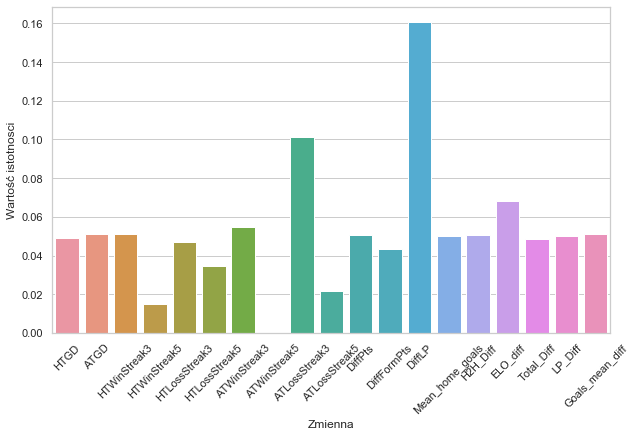

In [173]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X, y)
xb = pd.DataFrame({"Zmienna" : X.columns,
              "Wartość istotnosci": model.feature_importances_})
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
ax = sns.barplot(x="Zmienna", y="Wartość istotnosci", data=xb)
for label in ax.get_xticklabels():
    label.set_rotation(45)

Według stworzonego modelu klasyfikatora XGBoost najwekszą istotnością wykazują się nastepujące zmienne: DiffLP, ATWinStreak5 oraz ELO_diff.Wartości istotności większości pozostałych zmiennych oscyluje przy podobnej wartości. 

## Podsumowanie

Przedstawiłem w tym artykule różne, praktyczne sposoby selekcji zmiennych wybranych do modelu. Użeteczność akich działań jest bardzo duża. Rozpoczynając od określenia zmiennych, które mają nawiększy wpływ na wartość wyjściową poprzez zrozumienie danych wejściowych i wyciągniecie "predykcjnych" wniosków. Jak zauważyliścue, praktycznie wszystkie z tych sposbó dawały rózne zestawy nalepszych zmiennych. Ta własność jest zatem kluczowa do zdefiniowania stwierdzenia, że nie ma jednego najlepszego spsoobu wyboru zmiennych. Chciałoby się powiedzieć - "to zależy". Dokładnie, to zależy od problemu przez jakim stoimy, od rodzaju oraz charakterystyki zmiennych wejściowych ale rónież od tego jak przedstawia się zmienna wyjściowa. Często trudno się w tym połąpać, który sposób dla nas będzie nalpeszy ale zazwyczaj warto sprwadzić więcej niż jeden sposób. Przede wszystkim dlatego, że analizując poszczególne wyniki algorytmów dostajemy nową informację na temat danych. To w kontekscię predykcji jest istotne, ponieważ zazwyczaj rzucza nam nowe światło na rózne aspekty zagadanienia. 